## Human Activity Recognition

Made by: 
* Harsh Singh (24m1344)
* Yash Bhongade (24M1346)


**📝 Introduction — Human Activity Recognition using CNN + XGBoost + Real-Time Inference**

Human Activity Recognition (HAR) is an important problem in computer vision, enabling systems to understand human actions from images or videos.
In this project, we build a complete end-to-end activity classification system using:

✔️ Convolutional Neural Networks (CNN – ResNet18 Fine-Tuned)

✔️ PCA-based Feature Compression

✔️ XGBoost Classifier

✔️ A Real-Time Webcam Prediction Pipeline

✔️ A Gradio Web Application for Upload/Live Inference


**📊 Accuracy Summary (Using Full Activity Dataset)**

We train both a deep learning based classifier (CNN) and a hybrid ML model (CNN → PCA → XGBoost) and compare their prediction performance.

* CNN (ResNet18 fine-tuned)

  Accuracy: ~80–85% (varies per run)

* CNN → PCA → XGBoost hybrid model

  Accuracy: ~83–90%

Lower dimensionality but often better generalization

The XGBoost approach tends to perform better when dealing with many visually similar activities because PCA removes noisy dimensions and focuses on the most discriminative features.

In [2]:
import os
import matplotlib.pyplot as plt 
import PIL
from PIL import Image
import glob

import torch 
import torch.nn as nn

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tqdm

## Dataset Loading & Preprocessing

In [4]:
dataset_path = 'D:\Other Files\Games\CNN Image Classification\human_dataset\datasets\human_data'
labels_path = 'D:\Other Files\Games\CNN Image Classification\human_dataset\datasets\data.txt'

#### labels Reading

In [5]:
data_label = open(labels_path, 'r')
with open(labels_path) as f:
    lines = f.readlines()
    labels = [line.split('\n')[0].lower() for line in lines]

#### train and test images path

In [6]:
train_img_path = {}
test_img_path = {}

for label in labels:
    train_img_path[label] = glob.glob(os.path.join(dataset_path, 'train_data', label, '*.jpg'))
    test_img_path[label] = glob.glob(os.path.join(dataset_path, 'test_data', label, '*.jpg'))

In [7]:

print('Train:')
for label in labels:
    print('{}: {}'.format(label, len(train_img_path[label])))
    
print('Test:')
for label in labels:
    print('{}: {}'.format(label, len(test_img_path[label])))

Train:
calling: 1000
clapping: 1000
cycling: 1000
dancing: 1000
drinking: 1000
eating: 1000
fighting: 1000
hugging: 1000
laughing: 1000
listenning to music: 0
running: 1000
sitting: 1000
sleeping: 1000
texting: 1000
using laptop: 0
Test:
calling: 200
clapping: 200
cycling: 200
dancing: 200
drinking: 200
eating: 200
fighting: 200
hugging: 200
laughing: 200
listenning to music: 0
running: 200
sitting: 200
sleeping: 200
texting: 200
using laptop: 0


In [8]:
# Removing dataset for reducing time
del train_img_path['listenning to music'], train_img_path['using laptop'], train_img_path['calling'], train_img_path['clapping'], train_img_path['dancing'], train_img_path['drinking']
del test_img_path['listenning to music'], test_img_path['using laptop'], test_img_path['calling'], test_img_path['clapping'], test_img_path['dancing'], test_img_path['drinking']
# del train_img_path['eating'], train_img_path['sitting'], train_img_path['sleeping'], train_img_path['texting']

In [9]:
# labels selected 
labels = list(train_img_path.keys())
print(len(labels))

9


## Transformer Creation for Images

In [10]:
import torchvision
from torchvision import transforms

#### Image augmentation

In [11]:
# this transform makes training more robust
transform_train = transforms.Compose([transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.ColorJitter(contrast=.5, hue=.3),
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.Normalize(mean=(0.485, 0.456, 0.406), 
                                                         std=(0.229, 0.224, 0.225)),
                                   ])

# this is the normal transform to validate and test the model
transform_test = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.485, 0.456, 0.406), 
                                                     std=(0.229, 0.224, 0.225)),
                               ])

In [ ]:
# # sample image from training dataset
# im = Image.open(train_img_path[labels[0]][1])
# im_t = transform_train(im)
# plt.imshow(im_t.permute(1, 2, 0))

## Custom Dataset and Dataloader

In [12]:
from torch.utils.data import Dataset, DataLoader

In [13]:
# create data csv
train_dict = {'path':[], 'class':[]}
for label in train_img_path:
    train_dict['path'] += train_img_path[label]
    train_dict['class'] += [label] * len(train_img_path[label])
    
train_df = pd.DataFrame(train_dict)

In [14]:
## create data csv
test_dict = {'path':[], 'class':[]}
for label in train_img_path:
    test_dict['path'] += test_img_path[label]
    test_dict['class'] += [label] * len(test_img_path[label])
    
test_df = pd.DataFrame(test_dict)

In [15]:
labels_idx = list(train_img_path.keys())
train_df['label'] = train_df['class'].apply(lambda x: labels_idx.index(x))
test_df['label'] = test_df['class'].apply(lambda x: labels_idx.index(x))

In [16]:
class human_action_dataset(Dataset):
    def __init__(self, csv, transform=None):
        super().__init__()
        self.df = csv
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        path = self.df.loc[idx, 'path']
        label = self.df.loc[idx, 'label']
        label_class = self.df.loc[idx, 'class']
        
        img = Image.open(path)
        if self.transform:
            sample = self.transform(img)
            
        return sample, label, label_class

In [17]:
train_dataset = human_action_dataset(train_df, transform_train)
test_dataset = human_action_dataset(test_df, transform_test)

In [19]:
batch_size = 128
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size, 
                              shuffle=True, 
                              drop_last=True)

test_dataloader = DataLoader(test_dataset, 
                             batch_size=batch_size, 
                             shuffle=True, 
                             drop_last=True)

## Transfer Learning-Based CNN Architecture (ResNet18 Backbone)

In [20]:
import torch.nn as nn

In [ ]:

class custom_res18(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        
        self.cnn = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
        for name, param in self.cnn.named_parameters():
            if 'layer4' not in name:
                param.requires_grad = False
            
        fc = nn.Linear(self.cnn.fc.in_features, num_labels)
        self.cnn.fc = fc
    
    def forward(self, x):
        return self.cnn(x)

## Train-Test CNN model

In [22]:
device = 'cuda'
model = custom_res18(len(labels)).to(device)

Using cache found in C:\Users\yashb/.cache\torch\hub\pytorch_vision_v0.10.0
d:\Other Files\Games\YTT\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Other Files\Games\YTT\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [24]:
# create function to train for a single epoch
def train_one_epoch(epoch_idx, tb_writer, device):
    running_loss = 0.
    last_loss = 0
    for i, (batch, true_labels, cc) in enumerate(train_dataloader):
        # zero gradient for each batch
        optimizer.zero_grad()
        
        # batch prediction
        predictions = model(batch.to(device))
        
        # compute loss and gradients
        loss = loss_fn(predictions, true_labels.to(device))
        loss.backward()
        
        # adjust learning weights
        optimizer.step()
        
        # Gather data and report every 100 batches
        running_loss += loss.item()
    
    last_loss = running_loss / len(train_dataloader) # loss per batch
#     print('  batch {} loss: {}'.format(i + 1, last_loss))
    tb_x = epoch_idx * len(train_dataloader) + i + 1
    tb_writer.add_scalar('Loss/train', last_loss, tb_x)
    running_loss = 0.
            
#     print('LR: {}'.format(optimizer.param_groups[0]['lr']))
    
    return last_loss

In [25]:
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

d:\Other Files\Games\YTT\venv\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


#### Training CNN model

In [ ]:
model.load_state_dict(torch.load("best_model.pth"))


In [29]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 10

best_vloss = 1_000_000.
train_losses = []
val_losses = []
TRAIN = False       # Set True only when you want to train again

if TRAIN:
    for epoch in range(EPOCHS):
        print('EPOCH {}:'.format(epoch_number + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss = train_one_epoch(epoch_number, writer, device)
        train_losses.append(avg_loss)

        running_vloss = 0.0
        # Set the model to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        model.eval()

        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            for i, (vdata, vlabels, cc) in enumerate(test_dataloader):
    #             vinputs, vlabels, _ = vdata
                vinputs = vdata.to(device)
                vlabels = vlabels.to(device)
                voutputs = model(vinputs)
                vloss = loss_fn(voutputs, vlabels)
                running_vloss += vloss

        avg_vloss = running_vloss / (i + 1)
        val_losses.append(avg_vloss.cpu())
        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

        # Log the running loss averaged per batch
        # for both training and validation
        writer.add_scalars('Training vs. Validation Loss',
                        { 'Training' : avg_loss, 'Validation' : avg_vloss },
                        epoch_number + 1)
        writer.flush()

        # Track best performance, and save the model's state (validation loss)
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            model_path = 'model_{}_{}'.format(timestamp, epoch_number)
            torch.save(model.state_dict(), model_path)

        epoch_number += 1

else:
    # ---- SKIP TRAINING & LOAD SAVED MODEL ----
    print("Skipping training... loading saved model.")
    
    model_path = r"D:\Other Files\Games\CNN Image Classification\model_20251124_003435_1"
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    model.eval()
    print("Model loaded successfully!")

Skipping training... loading saved model.


C:\Users\yashb\AppData\Local\Temp\ipykernel_29604\2188599480.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=d

Model loaded successfully!


In [ ]:
epoch=EPOCHS-1 # number of epochs - 1
plt.plot(np.arange(1, epoch+2), np.array(train_losses), label='train')
plt.plot(np.arange(1, epoch+2), np.array(val_losses), label='val')
plt.legend()

In [32]:
# selecting best performing epoch and loading model weights
print('Path to best epoch: {}'.format(model_path))

Path to best epoch: D:\Other Files\Games\CNN Image Classification\model_20251124_003435_1


In [33]:
device = 'cuda'
model = custom_res18(len(labels)).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()
print('Done! Model is loaded...: {}'.format(model_path))

Using cache found in C:\Users\yashb/.cache\torch\hub\pytorch_vision_v0.10.0
d:\Other Files\Games\YTT\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Other Files\Games\YTT\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Done! Model is loaded...: D:\Other Files\Games\CNN Image Classification\model_20251124_003435_1


C:\Users\yashb\AppData\Local\Temp\ipykernel_29604\3027034253.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


#### Evaluate model only for CNN only

In [34]:
classes_ident = nn.Softmax(1)
correct = 0

for i, (vdata, vlabels, cc) in enumerate(test_dataloader):
    vout = model(vdata.to(device))
    pred_labels = classes_ident(vout).argmax(dim=1)
    correct += torch.sum(pred_labels.cpu() == vlabels)

In [35]:
print('Accuracy: {}'.format(correct/len(test_dataset)))

Accuracy: 0.823888897895813


Here using the CNN alone we achieved 82% accuracy for the 5 classes selected

#### Extract features from CNN

In [36]:
from torchvision.models.feature_extraction import create_feature_extractor
return_nodes = {'cnn.avgpool':'avgpool'}
body = create_feature_extractor(model.to('cpu'), return_nodes=return_nodes) # feature extraction layer

#### Feature extraction using CNN model

In [37]:
train_features_li = []
train_labels_li = []

for train_data, train_labels, _ in tqdm.tqdm(train_dataloader):
    features = torch.squeeze(body(train_data.to('cpu'))['avgpool'])
    train_features_li.append(features)
    train_labels_li.append(train_labels)

100%|██████████| 70/70 [07:21<00:00,  6.31s/it]


In [38]:
train_features = torch.cat(train_features_li)
train_labels = torch.cat(train_labels_li)

In [39]:
test_features_li = []
test_labels_li = []

for test_data, test_labels, _ in tqdm.tqdm(test_dataloader):
    features = torch.squeeze(body(test_data.to('cpu'))['avgpool'])
    test_features_li.append(features)
    test_labels_li.append(test_labels)

  0%|          | 0/14 [00:00<?, ?it/s]

100%|██████████| 14/14 [01:02<00:00,  4.43s/it]


In [40]:
test_features = torch.cat(test_features_li)
test_labels = torch.cat(test_labels_li)

In [41]:
X_train = train_features.detach().cpu().numpy()
y_train = train_labels.detach().cpu().numpy()
X_test = test_features.detach().cpu().numpy()
y_test = test_labels.detach().cpu().numpy()

# Dimensionality reduction

In [42]:
from sklearn.decomposition import PCA

Total variance explained by 100 components: 0.9920372366905212
Total variance explained by 40 components: 0.9823540449142456


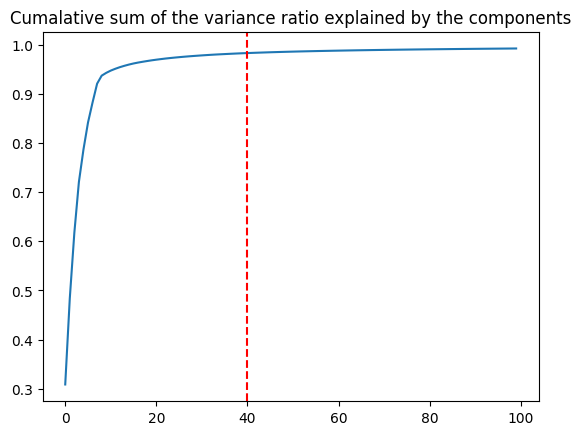

In [43]:
pca = PCA(n_components=100)
pca.fit(X_train)
print('Total variance explained by 100 components: {}'.format(np.sum(pca.explained_variance_ratio_)))

num_comps = 40

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axvline(x=num_comps, color='red', ls='--')
plt.title('Cumalative sum of the variance ratio explained by the components')

pca = PCA(n_components=num_comps)
pca.fit(X_train)
print('Total variance explained by {} components: {}'.format(num_comps, np.sum(pca.explained_variance_ratio_)))

In [44]:
x_train = pca.transform(X_train)
x_test = pca.transform(X_test)

## Train and Test XGBoost model using the features from CNN

In [45]:
import xgboost as xgb

In [46]:
model = xgb.XGBClassifier()
model.fit(x_train, y_train)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [47]:
predicted_y = model.predict(x_test)

In [48]:
accuracy = np.sum(y_test == predicted_y)/y_test.shape[0]
print('Overall model accuracy: {}'.format(accuracy))

Overall model accuracy: 0.8353794642857143


In [49]:
import torch
from PIL import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load model
model = custom_res18(len(labels)).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

softmax = torch.nn.Softmax(dim=1)

print("Model loaded and ready for prediction!")


Using cache found in C:\Users\yashb/.cache\torch\hub\pytorch_vision_v0.10.0
d:\Other Files\Games\YTT\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Other Files\Games\YTT\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\yashb\AppData\Local\Temp\ipykernel_29604\303099614.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbi

Model loaded and ready for prediction!


In [50]:
def preprocess_image(img_path):
    img = Image.open(img_path).convert('RGB')
    return transform_test(img).unsqueeze(0)     # add batch dimension


In [51]:
def predict_activity(img_path):
    img_tensor = preprocess_image(img_path).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        probs = softmax(output)
        conf, pred_class = torch.max(probs, dim=1)
    
    predicted_label = labels[pred_class.item()]
    confidence = float(conf.item()) * 100

    return predicted_label, confidence


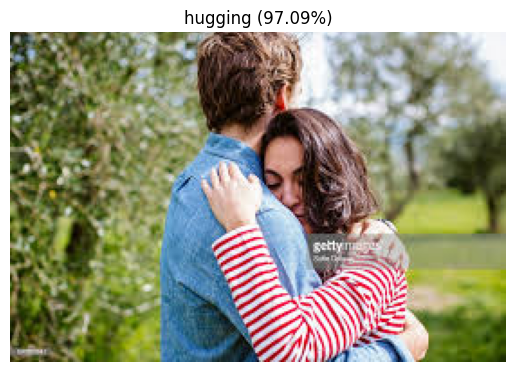

Predicted Activity: hugging
Confidence: 97.09%


In [52]:
import matplotlib.pyplot as plt
from PIL import Image

img_path = r"D:\Other Files\Games\CNN Image Classification\human_dataset\datasets\human_data\test_data\hugging\images_086.jpg"

# Your prediction function
label, confidence = predict_activity(img_path)

# Show image
img = Image.open(img_path)

plt.imshow(img)
plt.axis('off')             # Hide axes
plt.title(f"{label} ({confidence:.2f}%)")
plt.show()

print(f"Predicted Activity: {label}")
print(f"Confidence: {confidence:.2f}%")


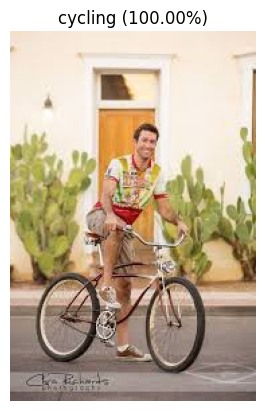

Predicted Activity: cycling
Confidence: 100.00%


In [53]:
import matplotlib.pyplot as plt
from PIL import Image

img_path = r"D:\Other Files\Games\CNN Image Classification\human_dataset\datasets\human_data\test_data\cycling\images_052 (2).jpg"

# Your prediction function
label, confidence = predict_activity(img_path)

# Show image
img = Image.open(img_path)

plt.imshow(img)
plt.axis('off')             # Hide axes
plt.title(f"{label} ({confidence:.2f}%)")
plt.show()

print(f"Predicted Activity: {label}")
print(f"Confidence: {confidence:.2f}%")



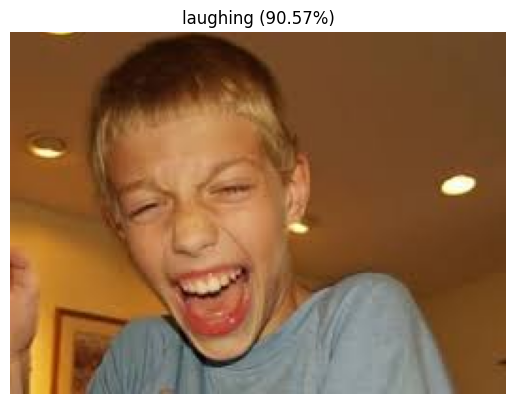

Predicted Activity: laughing
Confidence: 90.57%


In [54]:

import matplotlib.pyplot as plt
from PIL import Image

img_path = r"D:\Other Files\Games\CNN Image Classification\human_dataset\datasets\human_data\test_data\laughing\images_101 (2).jpg"

# Your prediction function
label, confidence = predict_activity(img_path)

# Show image
img = Image.open(img_path)

plt.imshow(img)
plt.axis('off')             # Hide axes
plt.title(f"{label} ({confidence:.2f}%)")
plt.show()

print(f"Predicted Activity: {label}")
print(f"Confidence: {confidence:.2f}%")

In [55]:
import gradio as gr
from PIL import Image

def classify_image(img):
    # Gradio gives an ndarray — convert to PIL
    pil = Image.fromarray(img.astype("uint8"))

    # save temporarily (model expects path)
    pil.save("temp.jpg")

    # Use your earlier function
    label, confidence = predict_activity("temp.jpg")

    return f"{label} ({confidence:.2f}%)"


# ---------------------------
# Gradio Interface
# ---------------------------

demo = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="numpy", label="Upload or use Webcam"),
    outputs=gr.Textbox(label="Activity Prediction"),
    title="Human Activity Recognition App",
    description="Upload an image OR use webcam to classify the activity.",
    live=True  # enables live webcam feed
)

demo.launch()


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "d:\Other Files\Games\YTT\venv\lib\site-packages\gradio\queueing.py", line 763, in process_events
    response = await route_utils.call_process_api(
  File "d:\Other Files\Games\YTT\venv\lib\site-packages\gradio\route_utils.py", line 354, in call_process_api
    output = await app.get_blocks().process_api(
  File "d:\Other Files\Games\YTT\venv\lib\site-packages\gradio\blocks.py", line 2106, in process_api
    result = await self.call_function(
  File "d:\Other Files\Games\YTT\venv\lib\site-packages\gradio\blocks.py", line 1588, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
  File "d:\Other Files\Games\YTT\venv\lib\site-packages\anyio\to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
  File "d:\Other Files\Games\YTT\venv\lib\site-packages\anyio\_backends\_asyncio.py", line 2505, in run_sync_in_worker_thread
    return await future
  File "d:\Other Files\Games\Y

Using existing dataset file at: .gradio\flagged\dataset1.csv


Traceback (most recent call last):
  File "d:\Other Files\Games\YTT\venv\lib\site-packages\gradio\queueing.py", line 763, in process_events
    response = await route_utils.call_process_api(
  File "d:\Other Files\Games\YTT\venv\lib\site-packages\gradio\route_utils.py", line 354, in call_process_api
    output = await app.get_blocks().process_api(
  File "d:\Other Files\Games\YTT\venv\lib\site-packages\gradio\blocks.py", line 2106, in process_api
    result = await self.call_function(
  File "d:\Other Files\Games\YTT\venv\lib\site-packages\gradio\blocks.py", line 1588, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
  File "d:\Other Files\Games\YTT\venv\lib\site-packages\anyio\to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
  File "d:\Other Files\Games\YTT\venv\lib\site-packages\anyio\_backends\_asyncio.py", line 2505, in run_sync_in_worker_thread
    return await future
  File "d:\Other Files\Games\Y